In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM, Dense

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')


In [2]:
df = pd.read_csv('data/train_cleaned.csv')
df_labels = pd.read_csv('data/labels_q.csv')

In [3]:
df_labels = df_labels[['session_id', 'q3']]

df_labels.columns = ['session_id', 'label']

In [4]:
df = pd.get_dummies(df, columns=['event_name', 'fqid', 'room_fqid', 'fullscreen', 'text_fqid'])

num_cols = ['elapsed_time', 'level', 'room_coor_x', 'room_coor_y', 'event_index', 'elapsed_time_diff']

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols]).astype('float32')

df = df.merge(df_labels, on='session_id')

In [5]:
# sort by session_id and elapsed_time
df = df.sort_values(['session_id', 'elapsed_time'])

In [6]:

def create_sequence(session_id):
    sequence = df[df['session_id'] == session_id]

    X = sequence.drop(['session_id','label'], axis=1).values
    y = sequence['label'].iloc[-1]

    # if sequence is not 220, pad with zeros
    if X.shape[0] < 220:
        X = np.pad(X, ((0, 220-X.shape[0]), (0,0)), 'constant')

    if X.shape[0] > 220:
        X = X[:220]
    return X, y

Xs, ys = [], []

for session_id in df['session_id'].unique():
    X, y = create_sequence(session_id)
    if X.shape[0] > 1: # filter out sessions with only one event
        Xs.append(X)
        ys.append(y)

Xs = np.array(Xs)
ys = np.array(ys)

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

# get validation set which is half of the test set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [7]:
model = Sequential()
model.add(LSTM(128, input_shape=(220, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=32)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/8


2023-04-09 20:29:36.080185: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


590/590 [==============================] - 29s 46ms/step - loss: 0.2485 - accuracy: 0.9332 - val_loss: 0.2529 - val_accuracy: 0.9308
Epoch 2/8
590/590 [==============================] - 27s 45ms/step - loss: 0.2384 - accuracy: 0.9342 - val_loss: 0.2541 - val_accuracy: 0.9308
Epoch 3/8
590/590 [==============================] - 27s 45ms/step - loss: 0.2374 - accuracy: 0.9342 - val_loss: 0.2450 - val_accuracy: 0.9308
Epoch 4/8
590/590 [==============================] - 26s 45ms/step - loss: 0.2372 - accuracy: 0.9342 - val_loss: 0.2450 - val_accuracy: 0.9308
Epoch 5/8
590/590 [==============================] - 27s 46ms/step - loss: 0.2353 - accuracy: 0.9342 - val_loss: 0.2449 - val_accuracy: 0.9308
Epoch 6/8
590/590 [==============================] - 27s 46ms/step - loss: 0.2343 - accuracy: 0.9342 - val_loss: 0.2471 - val_accuracy: 0.9308
Epoch 7/8
590/590 [==============================] - 26s 45ms/step - loss: 0.2337 - accuracy: 0.9342 - val_loss: 0.2463 - val_accuracy: 0.9308
Epoch 8/8

In [8]:
# predict on validation set
y_pred = model.predict(X_val)

74/74 [==============================] - 1s 13ms/step


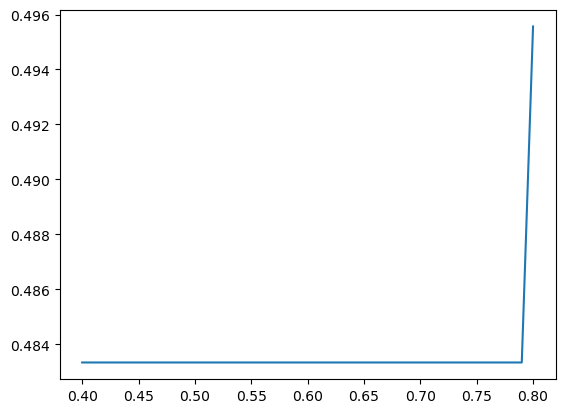

In [9]:
# plot best threshold for f1 score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

threholds = np.arange(0.4, 0.81, 0.01)
f1_scores = []

for threhold in threholds:
    f1_scores.append(f1_score(y_val, y_pred > threhold, average='macro'))

plt.plot(threholds, f1_scores)
plt.show()

In [10]:
# get best threshold
best_threshold = threholds[np.argmax(f1_scores)]
print(best_threshold)

0.8000000000000004


In [11]:
# best f1 score
print(np.max(f1_scores))

0.49556434631927043


In [12]:
labels = pd.read_csv('data/train_labels.csv')

labels

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1
...,...,...
424111,22100215342220508_q18,1
424112,22100215460321130_q18,1
424113,22100217104993650_q18,1
424114,22100219442786200_q18,1
